In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
data = pd.read_csv('../data/bybit_ethusdt_20240901-20240930.csv', parse_dates=['Timestamp'])
data.set_index('Timestamp', inplace=True)

In [12]:
# 移動平均線の計算
def calculate_sma(series, period):
    return series.rolling(window=period).mean()

short_ma_period = 5
long_ma_period = 20

data['short_ma'] = calculate_sma(data['Close'], short_ma_period)
data['long_ma'] = calculate_sma(data['Close'], long_ma_period)

# MACDの計算
def calculate_ema(series, period):
    return series.ewm(span=period, adjust=False).mean()

def calculate_macd(series, fast_period, slow_period, signal_period):
    macd_line = calculate_ema(series, fast_period) - calculate_ema(series, slow_period)
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    return macd_line, signal_line

macd_fast_period = 12
macd_slow_period = 26
macd_signal_period = 9

data['macd_line'], data['signal_line'] = calculate_macd(data['Close'], macd_fast_period, macd_slow_period, macd_signal_period)

# ADXの計算
def calculate_adx(df, period):
    df = df.copy()
    df['Prev_High'] = df['High'].shift(1)
    df['Prev_Low'] = df['Low'].shift(1)
    df['Prev_Close'] = df['Close'].shift(1)
    
    # True Range (TR) の計算
    df['High_Low'] = df['High'] - df['Low']
    df['High_PrevClose'] = abs(df['High'] - df['Prev_Close'])
    df['Low_PrevClose'] = abs(df['Low'] - df['Prev_Close'])
    df['TR'] = df[['High_Low', 'High_PrevClose', 'Low_PrevClose']].max(axis=1)
    
    # Directional Movement (DM) の計算
    df['Plus_DM'] = np.where((df['High'] - df['Prev_High']) > (df['Prev_Low'] - df['Low']),
                             np.maximum(df['High'] - df['Prev_High'], 0), 0)
    df['Minus_DM'] = np.where((df['Prev_Low'] - df['Low']) > (df['High'] - df['Prev_High']),
                              np.maximum(df['Prev_Low'] - df['Low'], 0), 0)
    
    # 平滑化平均の計算
    df['ATR'] = df['TR'].rolling(window=period).mean()
    df['Plus_DI'] = 100 * (df['Plus_DM'].rolling(window=period).mean() / df['ATR'])
    df['Minus_DI'] = 100 * (df['Minus_DM'].rolling(window=period).mean() / df['ATR'])
    
    # Directional Index (DX) の計算
    df['DX'] = 100 * (abs(df['Plus_DI'] - df['Minus_DI']) / (df['Plus_DI'] + df['Minus_DI']))
    
    # Average Directional Index (ADX) の計算
    df['ADX'] = df['DX'].rolling(window=period).mean()
    
    return df['ADX']

adx_period = 14
data['adx'] = calculate_adx(data, adx_period)


In [13]:
# シグナルの生成とポジション管理
data['Signal'] = 0
data['Position'] = 0
position = 0
entry_price = 0
adx_threshold = 25

for i in range(1, len(data)):
    current = data.iloc[i]
    previous = data.iloc[i - 1]
    
    # ロングエントリーの条件
    if (current['short_ma'] > current['long_ma']) and (previous['short_ma'] <= previous['long_ma']) and \
       (current['macd_line'] > current['signal_line']) and (previous['macd_line'] <= previous['signal_line']) and \
       (current['adx'] >= adx_threshold) and position == 0:
        data.at[data.index[i], 'Signal'] = 1
        position = 1
        entry_price = current['Close']
    
    # ショートエントリーの条件
    elif (current['short_ma'] < current['long_ma']) and (previous['short_ma'] >= previous['long_ma']) and \
         (current['macd_line'] < current['signal_line']) and (previous['macd_line'] >= previous['signal_line']) and \
         (current['adx'] >= adx_threshold) and position == 0:
        data.at[data.index[i], 'Signal'] = -1
        position = -1
        entry_price = current['Close']
    
    # ロングポジションのエグジット条件
    elif position == 1:
        if (current['Close'] >= entry_price * 1.02) or (current['Close'] <= entry_price * 0.99) or \
           (current['short_ma'] < current['long_ma']):
            data.at[data.index[i], 'Signal'] = 0
            position = 0
    
    # ショートポジションのエグジット条件
    elif position == -1:
        if (current['Close'] <= entry_price * 0.98) or (current['Close'] >= entry_price * 1.01) or \
           (current['short_ma'] > current['long_ma']):
            data.at[data.index[i], 'Signal'] = 0
            position = 0
    
    data.at[data.index[i], 'Position'] = position

In [14]:
# リターンの計算
data['Return'] = data['Close'].pct_change()
data['Strategy_Return'] = data['Return'] * data['Position'].shift(1)

# 累積リターンの計算
data['Cumulative_Market_Return'] = (1 + data['Return']).cumprod()
data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()

# パフォーマンスの評価
total_returns = data['Cumulative_Strategy_Return'].iloc[-1] - 1
annual_returns = data['Strategy_Return'].mean() * 252 * 24 * 60
annual_std = data['Strategy_Return'].std() * np.sqrt(252 * 24 * 60)
sharpe_ratio = annual_returns / annual_std if annual_std != 0 else 0

print(f"Total Strategy Returns: {total_returns * 100:.2f}%")
print(f"Annualized Returns: {annual_returns * 100:.2f}%")
print(f"Annualized Volatility: {annual_std * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Total Strategy Returns: -5.80%
Annualized Returns: -51.09%
Annualized Volatility: 10.42%
Sharpe Ratio: -4.90


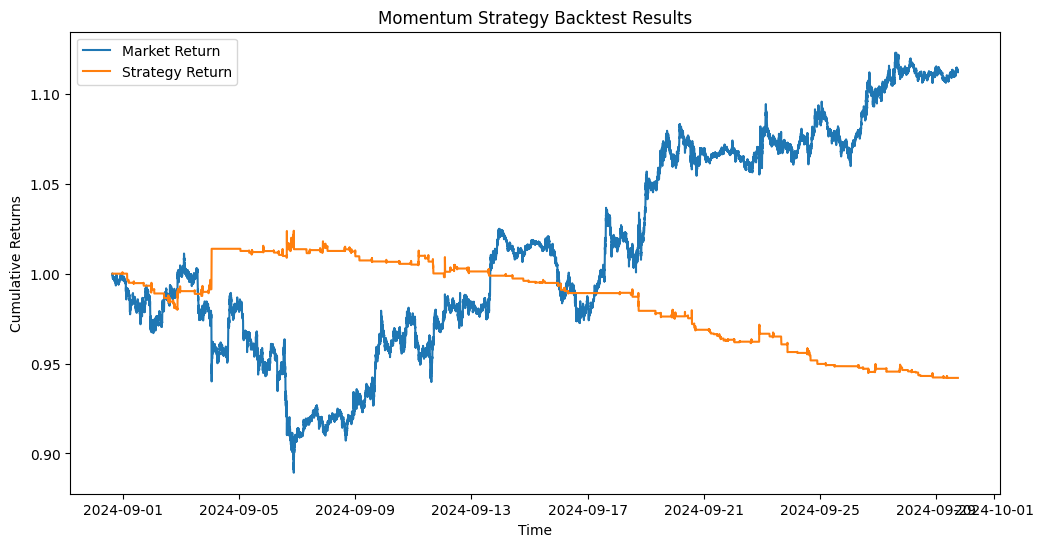

In [15]:
# 結果のプロット
plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Market_Return'], label='Market Return')
plt.plot(data['Cumulative_Strategy_Return'], label='Strategy Return')
plt.title('Momentum Strategy Backtest Results')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()